<a href="https://colab.research.google.com/github/sylvas-j/ML/blob/master/Tensorflow_works/SmartHome_ModelProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense
# from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# multi-class classification with Keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
)
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder,LabelEncoder,MinMaxScaler
)
# from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils

In [ ]:
# import mitosheet

####Basic Functions

In [125]:
class ResultSummary:
  # matrix = classification_report(actual,predicted,labels=[1,0])
  def classification_reportx(y_test,y_predicted):
    matrix = classification_report(y_test,y_predicted, labels=pd.unique(y_predicted))
    # matrix = classification_report(reverse_encoded_y_test,reverse_encoded_y_predicted, labels=pd.unique(reverse_encoded_y_predicted))
    print(matrix)
  # classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)


  # confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
  # pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
  def confusion_matrixx(y_test, y_pred,figsize1,figsize2):
    %matplotlib inline
    # fig, ax = plt.subplots(figsize=(12,10))
    fig, ax = plt.subplots(figsize=(figsize1,figsize2))
    # cm = confusion_matrix(reverse_encoded_y_test, reverse_encoded_y_predicted)
    cm = confusion_matrix(y_test, y_pred)
    # df_cm = pd.DataFrame(cm, index=pd.unique(reverse_encoded_y_test), columns=pd.unique(reverse_encoded_y_test))
    df_cm = pd.DataFrame(cm, index=pd.unique(y_test), columns=pd.unique(y_test))
    ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d", linewidths=.5, ax=ax)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    plt.ylabel('True label', fontweight='bold', fontsize = 18)
    plt.xlabel('Predicted label', fontweight='bold', fontsize = 18) 
    plt.show()
  # confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)
  


  def actual_n_predictions(reverse_encoded_y_test,reverse_encoded_y_predicted):
    for i in range(len(reverse_encoded_y_test)):
      print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))



# class for Y convertions
class TextLabelEncoderDummy:

  def labelencoder(y_df):
    encoder = LabelEncoder()
    encoder.fit(y_df)
    encoded_Y = encoder.transform(y_df)
    return encoded_Y, encoder


  def encoded_to_dummy(encoded_Y):
    # convert encoder variable to dummy variable
    uniques, ids = np.unique(encoded_Y, return_inverse=True)
    dummy_y = np_utils.to_categorical(ids, len(uniques))
    # dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y, uniques


  def reverse_dummy_to_encoded(y_test):
    reverse_dummy = uniques[y_test.argmax(1)]
    return reverse_dummy


  def reverse_encoded_to_text(reverse_dummy):
    reverse_encoded = encoder.inverse_transform(reverse_dummy)
    return reverse_encoded

#### For Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Ms Imumisen/smart_home_ds.csv")

#### For Jupyter Lab

#### Load Dataset

In [ ]:
data= pd.read_csv('D:\\Desktop Files\\weka data\\Ms Imumu\\hh130\\hh130.ann.features.csv')

In [ ]:
mitosheet.sheet(data)

MitoWidget(analysis_name='UUID-716c6500-92c2-499a-8c65-195f4a60998b', code_json='{"imports": "from mitosheet i…

In [ ]:
# MITO CODE START (DO NOT EDIT)

from mitosheet import * # Import necessary functions from Mito
register_analysis('UUID-716c6500-92c2-499a-8c65-195f4a60998b') # Let Mito know which analysis is being run

# Pivoted data into df2
df2 = pd.DataFrame(data={})

  
# MITO CODE END (DO NOT EDIT)

#### Data Wrangling and Processing

https://machinelearningmastery.com/data-preparation-techniques-for-machine-learning/

##### Data Cleaning: Identifying and correcting mistakes or errors in the data.
##### Feature Selection: Identifying those input variables that are most relevant to the task.
##### Data Transforms: Changing the scale or distribution of variables.
##### Feature Engineering: Deriving new variables from available data.
##### Dimensionality Reduction: Creating compact projections of the data.

In [4]:
data.head(4)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
0,2.0,7371.0,3.0,5722.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.498951,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
1,2.0,7373.0,3.0,5723.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.710117,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
2,2.0,7374.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698508,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
3,2.0,7375.0,3.0,5496.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.698326,0.0,0.0,0.0,34.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86400.0,0.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep


In [5]:
# Shuffled dataset and divide into dependent and independent set
data_shuffled = data.sample(frac=1)

X_df = data_shuffled.drop(labels=['activity'], axis=1)
y_df = data_shuffled['activity']

In [6]:
y_df

66772                Sleep
143314      Other_Activity
88340       Other_Activity
152697               Sleep
149617    Entertain_Guests
                ...       
147111    Entertain_Guests
117328      Other_Activity
52160       Other_Activity
109559      Other_Activity
108290      Other_Activity
Name: activity, Length: 157372, dtype: object

In [7]:
data.corr()

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
lastSensorEventHours,1.000000,0.998581,0.004958,-0.095645,-0.034804,0.200807,0.211911,0.133822,0.133822,0.148368,-0.034145,-0.005037,-0.021128,NaN,-0.112535,-0.134686,NaN,NaN,NaN,-0.047892,0.060029,0.244983,NaN,-0.010620,NaN,0.013302,0.161494,NaN,NaN,NaN,-0.148280,-0.286113,-0.266812,NaN,-0.118630,NaN
lastSensorEventSeconds,0.998581,1.000000,0.008052,-0.095057,-0.034541,0.200550,0.212061,0.132898,0.132898,0.147273,-0.035576,-0.005036,-0.022218,NaN,-0.110391,-0.135517,NaN,NaN,NaN,-0.047981,0.057927,0.245140,NaN,-0.011126,NaN,0.013728,0.161934,NaN,NaN,NaN,-0.148465,-0.285706,-0.266068,NaN,-0.118501,NaN
lastSensorDayOfWeek,0.004958,0.008052,1.000000,0.000474,0.001162,0.006574,0.005843,0.001191,0.001191,0.007354,-0.019884,-0.001008,-0.000396,NaN,0.011507,-0.009989,NaN,NaN,NaN,-0.029220,-0.005670,0.025060,NaN,-0.013449,NaN,-0.004421,-0.005140,NaN,NaN,NaN,0.000172,0.014175,0.043468,NaN,-0.015185,NaN
windowDuration,-0.095645,-0.095057,0.000474,1.000000,0.314408,-0.029632,-0.064792,0.021350,0.021350,0.036138,-0.313383,0.002748,-0.267356,NaN,-0.194275,0.135004,NaN,NaN,NaN,0.220572,-0.113131,-0.033380,NaN,0.001944,NaN,0.465764,0.354940,NaN,NaN,NaN,0.244148,0.192892,0.267309,NaN,0.471406,NaN
timeSinceLastSensorEvent,-0.034804,-0.034541,0.001162,0.314408,1.000000,-0.017921,-0.024935,0.015274,0.015274,0.031614,-0.101922,-0.142090,-0.079354,NaN,-0.067537,0.066774,NaN,NaN,NaN,0.043174,-0.038333,-0.014349,NaN,0.008017,NaN,0.131032,0.136262,NaN,NaN,NaN,0.099280,0.056365,0.083470,NaN,0.143315,NaN
prevDominantSensor1,0.200807,0.200550,0.006574,-0.029632,-0.017921,1.000000,0.477181,0.213728,0.213728,0.243117,0.075762,0.023516,0.021851,NaN,-0.272519,-0.240109,NaN,NaN,NaN,0.069521,0.182175,0.358118,NaN,0.014852,NaN,0.131014,0.191512,NaN,NaN,NaN,-0.076687,-0.222831,-0.174772,NaN,-0.032458,NaN
prevDominantSensor2,0.211911,0.212061,0.005843,-0.064792,-0.024935,0.477181,1.000000,0.152658,0.152658,0.170010,0.059542,0.012621,-0.003392,NaN,-0.132939,-0.197280,NaN,NaN,NaN,0.047996,0.131385,0.221019,NaN,0.020648,NaN,0.101285,0.151134,NaN,NaN,NaN,-0.077511,-0.225039,-0.179830,NaN,-0.044066,NaN
lastSensorID,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastSensorLocation,0.133822,0.132898,0.001191,0.021350,0.015274,0.213728,0.152658,1.000000,1.000000,0.858334,0.112540,-0.036664,0.011326,NaN,-0.394281,-0.282614,NaN,NaN,NaN,0.146376,0.196547,0.424363,NaN,0.117750,NaN,0.078590,0.241835,NaN,NaN,NaN,-0.091702,-0.171262,-0.159933,NaN,-0.073881,NaN
lastMotionLocation,0.148368,0.147273,0.007354,0.036138,0.031614,0.243117,0.170010,0.858334,0.858334,1.000000,0.122533,-0.070205,0.027712,NaN,-0.473448,-0.258489,NaN,NaN,NaN,0.110256,0.215386,0.466225,NaN,0.174744,NaN,0.102679,0.253689,NaN,NaN,NaN,-0.071910,-0.196571,-0.180780,NaN,-0.072909,NaN


In [8]:
data.corr().info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, lastSensorEventHours to sensorElTime-WorkArea
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lastSensorEventHours      25 non-null     float64
 1   lastSensorEventSeconds    25 non-null     float64
 2   lastSensorDayOfWeek       25 non-null     float64
 3   windowDuration            25 non-null     float64
 4   timeSinceLastSensorEvent  25 non-null     float64
 5   prevDominantSensor1       25 non-null     float64
 6   prevDominantSensor2       25 non-null     float64
 7   lastSensorID              25 non-null     float64
 8   lastSensorLocation        25 non-null     float64
 9   lastMotionLocation        25 non-null     float64
 10  complexity                25 non-null     float64
 11  activityChange            25 non-null     float64
 12  areaTransitions           25 non-null     float64
 13  numDistinctSensors        0 non-nu

In [9]:
corr_data = data.corr()

In [130]:
data.columns

Index(['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek',
       'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1',
       'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation',
       'lastMotionLocation', 'complexity', 'activityChange', 'areaTransitions',
       'numDistinctSensors', 'sensorCount-Bathroom', 'sensorCount-Bedroom',
       'sensorCount-Chair', 'sensorCount-DiningRoom', 'sensorCount-Hall',
       'sensorCount-Ignore', 'sensorCount-Kitchen', 'sensorCount-LivingRoom',
       'sensorCount-Office', 'sensorCount-OutsideDoor', 'sensorCount-WorkArea',
       'sensorElTime-Bathroom', 'sensorElTime-Bedroom', 'sensorElTime-Chair',
       'sensorElTime-DiningRoom', 'sensorElTime-Hall', 'sensorElTime-Ignore',
       'sensorElTime-Kitchen', 'sensorElTime-LivingRoom',
       'sensorElTime-Office', 'sensorElTime-OutsideDoor',
       'sensorElTime-WorkArea', 'activity'],
      dtype='object')

#### Filtering Columns with Contant Values

In [10]:
# Execute the following script to create a filter for constant features.
constant_filter = VarianceThreshold(threshold=0)
# Next, we need to simply apply this filter to our training set as shown in the following example:
constant_filter.fit(X_df)

VarianceThreshold(threshold=0)

In [11]:
# Execute the following script to see the number of non-constant features.

len(X_df.columns[constant_filter.get_support()])

25

In [12]:
# List of contants column
constant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[constant_filter.get_support()]]

In [13]:
constant_columns

['numDistinctSensors',
 'sensorCount-Chair',
 'sensorCount-DiningRoom',
 'sensorCount-Hall',
 'sensorCount-Office',
 'sensorCount-WorkArea',
 'sensorElTime-Chair',
 'sensorElTime-DiningRoom',
 'sensorElTime-Hall',
 'sensorElTime-Office',
 'sensorElTime-WorkArea']

In [14]:
X_df.head(2)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,numDistinctSensors,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Chair,sensorCount-DiningRoom,sensorCount-Hall,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-Office,sensorCount-OutsideDoor,sensorCount-WorkArea,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea
66772,4.0,16186.0,1.0,6916.0,1.0,1.0,1.0,1.0,1.0,1.0,0.397262,0.193754,4.0,0.0,0.0,30.79,0.0,0.0,0.0,1.22,0.0,2.34,0.0,0.0,0.0,18579.023730,0.000000,86400.0,86400.0,86400.0,5796.086463,18380.903615,5624.604626,86400.0,18321.496146,86400.0
143314,15.0,54359.0,2.0,40.0,2.0,7.0,7.0,7.0,7.0,7.0,1.255537,0.400000,12.0,0.0,0.0,12.46,0.0,0.0,0.0,2.37,0.0,19.52,0.0,0.0,0.0,1782.131977,5.827857,86400.0,86400.0,86400.0,24.701716,61.147305,0.000000,86400.0,83.310012,86400.0


In [15]:
# Finally, to remove constant features from training and test sets, we can use the transform() method of the constant_filter. 
# Execute the following script to do so:

# X_filtered = constant_filter.transform(X_df)
# test_features = constant_filter.transform(test_features)
# X_filtered.shape

# Executing this and skip transform if you want to filter quasi-constant before transform
X_df.drop(labels=constant_columns, axis=1, inplace=True)

In [16]:
X_df

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,complexity,activityChange,areaTransitions,sensorCount-Bathroom,sensorCount-Bedroom,sensorCount-Ignore,sensorCount-Kitchen,sensorCount-LivingRoom,sensorCount-OutsideDoor,sensorElTime-Bathroom,sensorElTime-Bedroom,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-OutsideDoor
66772,4.0,16186.0,1.0,6916.0,1.0,1.0,1.0,1.0,1.0,1.0,0.397262,0.193754,4.0,0.00,30.79,1.22,0.00,2.34,0.00,18579.023730,0.000000,5796.086463,18380.903615,5624.604626,18321.496146
143314,15.0,54359.0,2.0,40.0,2.0,7.0,7.0,7.0,7.0,7.0,1.255537,0.400000,12.0,0.00,12.46,2.37,0.00,19.52,0.00,1782.131977,5.827857,24.701716,61.147305,0.000000,83.310012
88340,17.0,63989.0,4.0,1617.0,6.0,1.0,1.0,1.0,1.0,1.0,1.418620,0.974644,1.0,0.00,7.21,20.52,0.00,0.00,6.62,3089.092322,0.000000,30.032800,13606.975648,3132.351775,24.918829
152697,6.0,24561.0,4.0,97.0,2.0,1.0,1.0,1.0,1.0,1.0,1.832263,0.453608,7.0,12.37,13.22,4.22,0.00,0.00,4.54,65.430724,0.000000,1.118316,32401.810013,27335.831208,47.430923
149617,13.0,48321.0,3.0,324.0,96.0,7.0,1.0,5.0,5.0,7.0,1.360964,0.138889,8.0,0.00,17.33,3.46,0.00,13.56,0.00,1019.436384,251.928246,0.000000,1142.955549,95.292958,2172.254684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147111,10.0,38277.0,3.0,42.0,1.0,1.0,9.0,7.0,7.0,7.0,1.949398,0.547619,6.0,0.00,7.60,12.94,7.25,6.56,0.00,50.485159,1.450795,6.557971,15.862899,0.000000,88.330390
117328,10.0,37982.0,3.0,34.0,0.0,1.0,1.0,5.0,5.0,9.0,1.664853,0.794118,7.0,0.00,7.61,5.52,0.00,19.16,2.06,4757.684891,1.370868,0.000000,3902.369510,4.605251,0.004948
52160,9.0,33199.0,5.0,29.0,1.0,5.0,0.0,9.0,9.0,9.0,1.753359,0.724138,6.0,0.00,7.59,7.95,0.00,16.77,2.04,347.044318,0.631944,1.874511,8478.582237,2.470412,0.000000
109559,19.0,70633.0,1.0,117.0,2.0,7.0,7.0,7.0,7.0,7.0,0.783777,0.307692,0.0,0.00,0.00,8.18,0.00,26.17,0.00,5349.362482,1710.130439,24.678184,1856.473664,0.000000,1705.196455


#### Filtering Out Of Contant-filteres dataset quasi-constant

In [17]:
# Let's create our quasi-constant filter. Execute the following script to do so:
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(X_df)

VarianceThreshold(threshold=0.01)

In [18]:
len(X_df.columns[qconstant_filter.get_support()])

25

In [19]:
qconstant_columns = [column for column in X_df.columns
                    if column not in X_df.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

0


In [20]:
for column in qconstant_columns:
    print(column)

In [21]:
train_features = qconstant_filter.transform(X_df)
# test_features = qconstant_filter.transform(test_features)

train_features.shape

(157372, 25)

#### Removing Duplicate Features

In [22]:
# We will use this method to first take a transpose of our dataset as shown below:
X_T = X_df.T
X_T.shape

(25, 157372)

In [23]:
# Let's find the total number of duplicate features in our dataset using the sum() method, chained with the duplicated() method as shown below.
print(X_T.duplicated().sum())

1


In [24]:
X_T.head(2)
# unique_features.head(2)

,66772,143314,88340,152697,149617,16936,66848,76884,11324,66578,138042,112024,128377,140603,108147,101755,57351,155536,128421,14297,86698,39902,13184,41069,60746,30598,18341,143019,56018,40292,34935,69827,13324,19726,69793,69527,91466,83642,117122,139469,...,107611,33104,18230,138201,91622,43603,3100,119755,13692,62144,36340,119636,111139,115694,141312,3622,146653,75763,128482,70903,1958,127749,47880,30799,133219,40733,136012,15142,24276,67090,106062,134522,126208,33415,63988,147111,117328,52160,109559,108290
lastSensorEventHours,4.0,15.0,17.0,6.0,13.0,23.0,7.0,6.0,14.0,23.0,12.0,9.0,7.0,8.0,13.0,11.0,8.0,14.0,7.0,9.0,10.0,0.0,8.0,8.0,20.0,9.0,8.0,14.0,22.0,7.0,7.0,12.0,8.0,11.0,12.0,11.0,9.0,18.0,9.0,21.0,...,11.0,21.0,7.0,12.0,10.0,16.0,10.0,22.0,9.0,8.0,13.0,22.0,9.0,7.0,9.0,11.0,9.0,20.0,8.0,19.0,10.0,0.0,10.0,9.0,12.0,8.0,8.0,11.0,9.0,8.0,8.0,19.0,14.0,22.0,9.0,10.0,10.0,9.0,19.0,13.0
lastSensorEventSeconds,16186.0,54359.0,63989.0,24561.0,48321.0,82819.0,25487.0,24156.0,52717.0,84717.0,44596.0,35813.0,28704.0,31685.0,47319.0,40835.0,31132.0,52951.0,28748.0,34680.0,36905.0,324.0,30274.0,32258.0,73397.0,34758.0,28902.0,52461.0,81627.0,26367.0,28507.0,45524.0,31364.0,40827.0,45345.0,42849.0,35645.0,68129.0,34117.0,78687.0,...,40018.0,77176.0,28714.0,46549.0,38159.0,59476.0,39257.0,80489.0,32771.0,29212.0,47889.0,80010.0,33722.0,27447.0,33766.0,40204.0,34397.0,75226.0,28809.0,69263.0,37777.0,984.0,36751.0,35958.0,46584.0,31184.0,29643.0,42985.0,32845.0,28908.0,30929.0,70935.0,51485.0,79612.0,35695.0,38277.0,37982.0,33199.0,70633.0,47593.0


In [25]:
unique_features = X_T.drop_duplicates(keep='first').T
# bNow, let's print the shape of our new training set without duplicate features:
unique_features.shape

(157372, 24)

In [26]:
duplicated_features = [dup_col for dup_col in X_df.columns if dup_col not in unique_features.columns]
duplicated_features

['lastSensorLocation']

#### Removing Correlated Features

In [36]:
# Execute the following script, to remove non-numeric features from the dataset.
num_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(unique_features.select_dtypes(include=num_colums).columns)
unique_numeric_features = unique_features[numerical_columns]

In [37]:
# Let's first create correlation matrix for the columns in the dataset and an empty set that will contain all the correlated features. 
# Execute the following script to do so:
correlated_features = set()
correlation_matrix = unique_numeric_features.corr()

In [38]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [39]:
# len(correlated_features)
print(correlated_features)

{'lastMotionLocation', 'sensorElTime-OutsideDoor', 'lastSensorEventSeconds'}


In [40]:
# The following script removes these columns from the dataset:
unique_numeric_features.drop(labels=correlated_features, axis=1, inplace=True)

In [41]:
unique_numeric_features.shape

(157372, 21)

In [42]:
# convert dataframe to numpy array
values = data.values
X, y = values[:, 0:36], values[:,36]
# X = X.reshape(len(X), 36, 1)

X = np.asarray(X).astype(np.float64)

#### Data transform and spliting

In [77]:
# encoder = LabelEncoder()
# encoder.fit(y_df)
# encoded_Y = encoder.transform(y_df)

encoded_Y, encoder = TextLabelEncoderDummy.labelencoder(y_df)

In [63]:
# convert encoder variable to dummy variable
# uniques, ids = np.unique(encoded_Y, return_inverse=True)
# dummy_y = np_utils.to_categorical(ids, len(uniques))
# # dummy_y = np_utils.to_categorical(encoded_Y)

dummy_y, uniques = TextLabelEncoderDummy.encoded_to_dummy(encoded_Y)

In [64]:
dummy_y.shape, encoded_Y.shape

((157372, 28), (157372,))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(unique_numeric_features, dummy_y,test_size=0.3,random_state=42)

In [66]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,test_size=0.5,random_state=42)

In [67]:
sc = StandardScaler()
S_train = sc.fit_transform(X_train)
S_val = sc.transform(X_val)
S_test = sc.transform(X_test)

In [68]:
X_train.shape,S_train.shape,y_train.shape

((110160, 21), (110160, 21), (110160, 28))

In [69]:
# pipe1a = Pipeline([
#     ('map', mapper),
# ])

In [70]:
y_train.shape, y_test.shape

((110160, 28), (23606, 28))

#### Training Model

In [71]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=21, activation='relu'))
    model.add(Dense(40, activation='relu'))
    # model.add(Dense(30, activation='relu'))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(28, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [72]:

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, S_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# print("Model accuracy: %.2f"% (accuracy*100))

Baseline: 71.19% (0.34%)


The restored model is compiled with the same arguments as the original model. Try running evaluate and predict with the loaded model:


####Retrain with modek.fit() and save model

In [94]:
model = baseline_model()
history = model.fit(S_train, y_train, batch_size=100, epochs=10, verbose=0, validation_data=None)
# create directory to save model
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=Yh5Mu0yOgE5J
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


######Saved to google drive

In [131]:
model.save("/content/drive/My Drive/Colab Notebooks/saved_model/my_model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/saved_model/my_model/assets


In [95]:
# my_model directory
!ls saved_model
# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


####Load model, evaluate and predict

In [96]:
saved_model = load_model('saved_model/my_model')
# Check its architecture
saved_model.summary()
# 4. evaluate network
score  = saved_model.evaluate(S_val, y_val, verbose=0)
print('Restored model,Loss: {:5.2f}%,  accuracy: {:5.2f}%'.format(100 * score[0], 100 * score[1]))
# 5. make predictions
predictions = saved_model.predict(S_test, verbose=0)
print(predictions)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 60)                1320      
_________________________________________________________________
dense_79 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_80 (Dense)             (None, 28)                1148      
Total params: 4,908
Trainable params: 4,908
Non-trainable params: 0
_________________________________________________________________
Restored model,Loss: 76.36%,  accuracy: 72.02%
[[6.8760949e-16 2.4736968e-09 3.2494940e-12 ... 1.2571147e-19
  2.1161957e-13 4.9049045e-14]
 [2.2324560e-09 8.7175388e-12 3.2333808e-06 ... 5.3789635e-04
  3.5392151e-08 3.2037210e-01]
 [3.1621442e-11 9.5733384e-17 1.9258473e-06 ... 9.8943021e-03
  1.1432456e-04 1.0464723e-01]
 ...
 [3.7556010e-13 1.2449483e-09 9.3696656e-08 ... 3.

#### Reverse Predictions variables to categorical variables

In [97]:
# Reverse dummy variable to encoder variable
# reverse_dummy_predicted = uniques[predictions.argmax(1)]
# print(pd.unique(reverse_dummy_predicted).shape)

reverse_dummy_predicted =TextLabelEncoderDummy.reverse_dummy_to_encoded(predictions)
print(pd.unique(reverse_dummy_predicted).shape)

# reverse encoded Y to categorical variables
# reverse_encoded_y_predicted = encoder.inverse_transform(reverse_dummy_predicted)
# reverse_encoded_y_predicted

reverse_encoded_y_predicted = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_dummy_predicted)
reverse_encoded_y_predicted

(25,)


array(['Sleep', 'Other_Activity', 'Watch_TV', ..., 'Sleep',
       'Other_Activity', 'Entertain_Guests'], dtype=object)

In [98]:
# reverse_test_dummy = uniques[y_test.argmax(1)]
# print(pd.unique(reverse_test_dummy).shape)

reverse_test_dummy =TextLabelEncoderDummy.reverse_dummy_to_encoded(y_test)
print(pd.unique(reverse_test_dummy).shape)

# reverse_encoded_y_test = encoder.inverse_transform(reverse_test_dummy)
# reverse_encoded_y_test

reverse_encoded_y_test = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_test_dummy)
reverse_encoded_y_test

(27,)


array(['Sleep', 'Other_Activity', 'Watch_TV', ..., 'Sleep',
       'Other_Activity', 'Entertain_Guests'], dtype=object)

In [99]:
pd.unique(reverse_encoded_y_predicted).shape, pd.unique(reverse_encoded_y_test).shape

((25,), (27,))

In [100]:
pd.unique(reverse_encoded_y_predicted), pd.unique(reverse_encoded_y_test)

(array(['Sleep', 'Other_Activity', 'Watch_TV', 'Work_On_Computer',
        'Entertain_Guests', 'Personal_Hygiene', 'Phone', 'Enter_Home',
        'Groom', 'Dress', 'Toilet', 'Bed_Toilet_Transition', 'Drink',
        'Leave_Home', 'Read', 'Cook', 'Sleep_Out_Of_Bed', 'Eat', 'Relax',
        'Work_At_Table', 'Cook_Lunch', 'Step_Out', 'Bathe', 'Wash_Dishes',
        'Eat_Breakfast'], dtype=object),
 array(['Sleep', 'Other_Activity', 'Watch_TV', 'Work_On_Computer',
        'Entertain_Guests', 'Personal_Hygiene', 'Phone', 'Leave_Home',
        'Relax', 'Toilet', 'Enter_Home', 'Groom', 'Dress', 'Read',
        'Wash_Dishes', 'Work_At_Table', 'Bed_Toilet_Transition', 'Drink',
        'Bathe', 'Sleep_Out_Of_Bed', 'Work', 'Cook', 'Eat_Breakfast',
        'Eat', 'Step_Out', 'Cook_Lunch', 'Eat_Lunch'], dtype=object))

In [101]:
# df_pred = pd.DataFrame(pd.unique(reverse_encoded_y_predicted), columns=['predicted'])
# df_pred
# df_test = pd.DataFrame(pd.unique(reverse_encoded_y_test), columns=['predicted'])
# # df_test
# # df_pred_test = pd.concat(df_pred,)

In [102]:
# new = df_test.merge(df_pred,on=['predicted'],how='outer')
# new

In [103]:
# from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
# from sklearn.multioutput import MultiOutputRegressor,RegressorChain
# from sklearn.svm import LinearSVR
# from sklearn.tree import DecisionTreeRegressor

# def run_regression(X_train, y_train,X_test,y_test):
#     ESTIMATORS = {
#         "K-nn": KNeighborsRegressor(),                          # Accept default parameters
#         "Linear regression": LinearRegression(),
#         "RandomForestRegressor": RandomForestRegressor(),
#         "Decision Tree Regressor":DecisionTreeRegressor(),
#         "RegressorChain Regressor":RegressorChain(DecisionTreeRegressor()),
#         "MultiOutputRegressor Regressor":MultiOutputRegressor(LinearRegression()),
#         "RegressorChain_Linear Regressor":RegressorChain(LinearRegression()),
#         "MultiOutput_DecisionTree Regressor":MultiOutputRegressor(DecisionTreeRegressor())
#     }
#     # 9.1 Create an empty dictionary to collect prediction values
#     y_test_predict = dict()
#     y_mse = dict()
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) #cross_val_predict
#     for name, estimator in ESTIMATORS.items():     
#         estimator.fit(X_train, y_train)                    # fit() with instantiated object
#         y_test_predict[name] = estimator.predict(X_test)   # Make predictions and save it in dict under key: name
#         y_mse[name] = mean_squared_error(y_test, estimator.predict(X_test))
#         print('Predicted: %s' % y_mse[name])
#     return y_test_predict

##Result Analysis

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

#####Classification Report

                       precision    recall  f1-score   support

                Sleep       0.92      0.94      0.93      1875
       Other_Activity       0.68      0.74      0.71      7195
             Watch_TV       0.73      0.76      0.75      2215
     Work_On_Computer       0.65      0.44      0.52       480
     Entertain_Guests       0.75      0.85      0.79      6161
     Personal_Hygiene       0.65      0.69      0.67      1905
                Phone       0.52      0.15      0.23       448
           Enter_Home       0.83      0.75      0.79       253
                Groom       0.67      0.52      0.58       504
                Dress       0.66      0.33      0.44       405
               Toilet       0.61      0.43      0.50       776
Bed_Toilet_Transition       0.90      0.90      0.90       284
                Drink       0.59      0.14      0.22       166
           Leave_Home       0.64      0.24      0.35       289
                 Read       0.89      0.62      0.73  

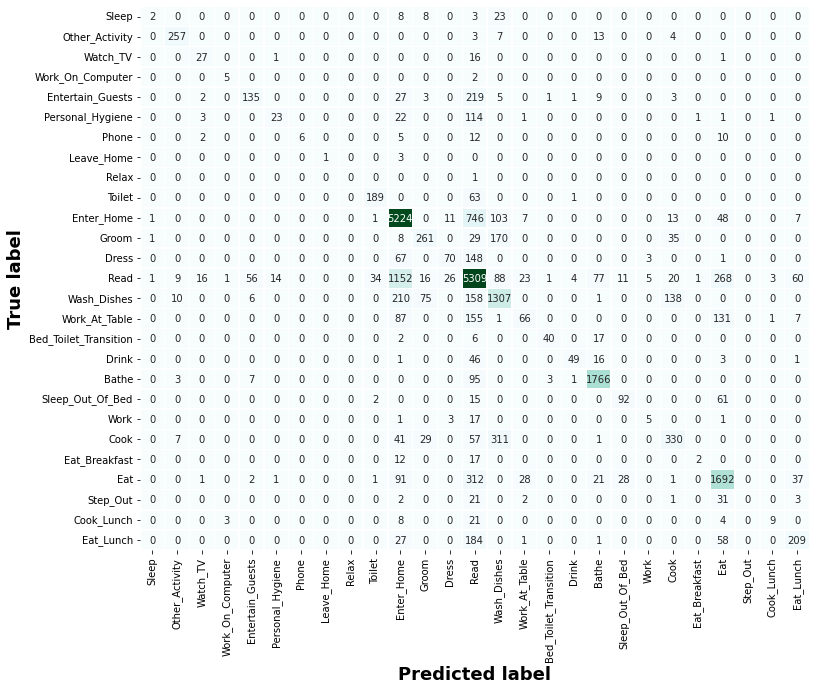

Streaming output truncated to the last 5000 lines.
Test: Watch_TV -------- Predicted: (Watch_TV)
Test: Watch_TV -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Sleep -------- Predicted: (Sleep)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Toilet -------- Predicted: (Personal_Hygiene)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Toilet -------- Predicted: (Toilet)
Test: Sl

In [126]:
# matrix = classification_report(actual,predicted,labels=[1,0])
ResultSummary.classification_reportx(reverse_encoded_y_test,reverse_encoded_y_predicted)
ResultSummary.confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)
ResultSummary.actual_n_predictions(reverse_encoded_y_test,reverse_encoded_y_predicted)

In [105]:
23606 - 23498
# 143

108

In [106]:
from sklearn.metrics import precision_score
precision = precision_score(reverse_encoded_y_test, reverse_encoded_y_predicted, average='micro')
print('Precision: %.3f' % precision)

Precision: 0.723


In [107]:
pd.unique(reverse_encoded_y_test)

array(['Sleep', 'Other_Activity', 'Watch_TV', 'Work_On_Computer',
       'Entertain_Guests', 'Personal_Hygiene', 'Phone', 'Leave_Home',
       'Relax', 'Toilet', 'Enter_Home', 'Groom', 'Dress', 'Read',
       'Wash_Dishes', 'Work_At_Table', 'Bed_Toilet_Transition', 'Drink',
       'Bathe', 'Sleep_Out_Of_Bed', 'Work', 'Cook', 'Eat_Breakfast',
       'Eat', 'Step_Out', 'Cook_Lunch', 'Eat_Lunch'], dtype=object)

#####Confusion matrix

In [ ]:
# pd.crosstab(reverse_encoded_y_test, reverse_encoded_y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

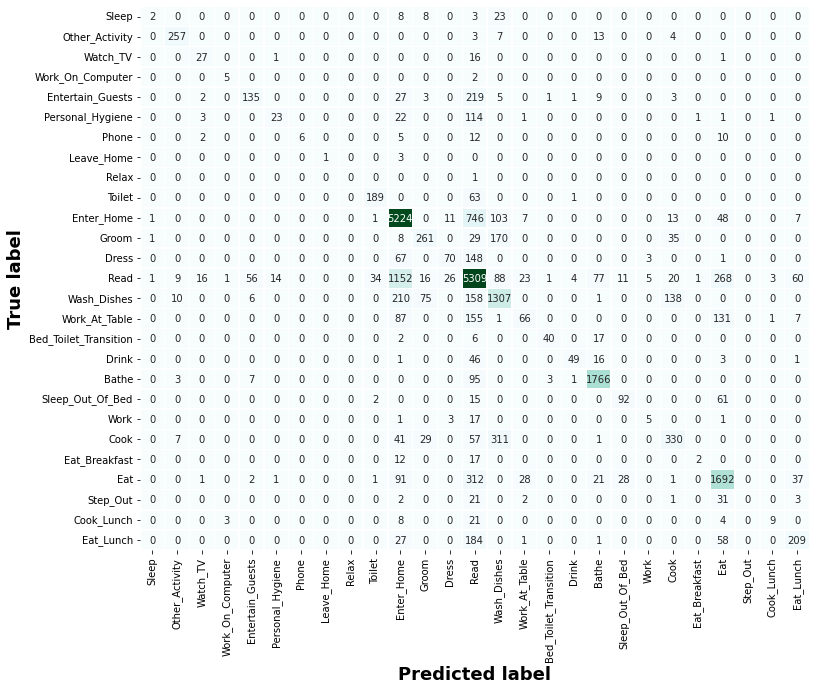

In [109]:
confusion_matrixx(reverse_encoded_y_test, reverse_encoded_y_predicted,12,10)

####Actual and predicted comparison

In [110]:
for i in range(len(reverse_encoded_y_test)):
    print("Test: %s -------- Predicted: (%s)" % (reverse_encoded_y_test[i], reverse_encoded_y_predicted[i]))

# pred = list()
# for i in range(4):
#     pred.append(uniques[predictions.argmax(1)])

Streaming output truncated to the last 5000 lines.
Test: Watch_TV -------- Predicted: (Watch_TV)
Test: Watch_TV -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Dress -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Sleep -------- Predicted: (Sleep)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Personal_Hygiene -------- Predicted: (Other_Activity)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Toilet -------- Predicted: (Personal_Hygiene)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Entertain_Guests -------- Predicted: (Entertain_Guests)
Test: Other_Activity -------- Predicted: (Other_Activity)
Test: Toilet -------- Predicted: (Toilet)
Test: Sl

####Playground

In [ ]:
# Let's create prediction and result display function
data_pred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,0,0]
data_pred_df = pd.DataFrame(data_pred, columns=['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek',
       'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1',
       'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation',
       'lastMotionLocation', 'complexity', 'activityChange', 'areaTransitions',
       'numDistinctSensors', 'sensorCount-Bathroom', 'sensorCount-Bedroom',
       'sensorCount-Chair', 'sensorCount-DiningRoom', 'sensorCount-Hall',
       'sensorCount-Ignore', 'sensorCount-Kitchen', 'sensorCount-LivingRoom',
       'sensorCount-Office', 'sensorCount-OutsideDoor', 'sensorCount-WorkArea',
       'sensorElTime-Bathroom', 'sensorElTime-Bedroom', 'sensorElTime-Chair',
       'sensorElTime-DiningRoom', 'sensorElTime-Hall', 'sensorElTime-Ignore',
       'sensorElTime-Kitchen', 'sensorElTime-LivingRoom',
       'sensorElTime-Office', 'sensorElTime-OutsideDoor',
       'sensorElTime-WorkArea', 'activity'], dtype='float64')

data_dropped = data_pred_df.drop(labels=['numDistinctSensors','sensorCount-Chair','sensorCount-DiningRoom',
 'sensorCount-Hall','sensorCount-Office','sensorCount-WorkArea','sensorElTime-Chair','sensorElTime-DiningRoom',
 'sensorElTime-Hall','sensorElTime-Office',
 'sensorElTime-WorkArea','lastSensorLocation','lastMotionLocation', 'sensorElTime-OutsideDoor', 'lastSensorEventSeconds'], axis=1)
# data_shuffled = data.sample(frac=1)
X_pred_df = data_dropped.drop(labels=['activity'], axis=1)
y_pred_df = data_dropped['activity']

# encode and dummy transform
encoded_Y_pred, encoder = TextLabelEncoderDummy.labelencoder(y_pred_df)
dummy_y_pred, uniques = TextLabelEncoderDummy.encoded_to_dummy(encoded_Y_pred)

# Scaling data
sc = StandardScaler()
# S_train = sc.fit_transform(X_train)
S_test_pred = sc.transform(X_pred_df)

# load model with evaluation dataset
saved_model = load_model("/content/drive/My Drive/Colab Notebooks/saved_model/my_model")
saved_model.summary()
score  = saved_model.evaluate(S_val, y_val, verbose=0)
print('Restored model,Loss: {:5.2f}%,  accuracy: {:5.2f}%'.format(100 * score[0], 100 * score[1]))

# 5. make predictions
preds = saved_model.predict(S_test, verbose=0)
print(pred)

# Reverse predictios
reverse_dummy_pred =TextLabelEncoderDummy.reverse_dummy_to_encoded(pred)
print(pd.unique(reverse_dummy_pred).shape)

reverse_encoded_y_pred = TextLabelEncoderDummy.reverse_encoded_to_text(reverse_dummy_pred)
reverse_encoded_y_pred

# Show output
ResultSummary.classification_reportx(y_pred_df,reverse_encoded_y_pred)
ResultSummary.confusion_matrixx(y_pred_df, reverse_encoded_y_pred,12,10)
ResultSummary.actual_n_predictions(y_pred_df,reverse_encoded_y_pred)

In [116]:
print(predictions.shape, y_test.shape)

(23606, 28) (23606, 28)


In [ ]:
for layer in model.layers:
    weights = layer.get_weights()

b# from keras.utils import plot_model
# plot_model(model, to_file='/tmp/model.png', show_shapes=True,)
weights

In [ ]:
# Now we can check the model’s performance on test data:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [129]:
# Saved datasets and download
from google.colab import files
# unique_numeric_features.to_csv('unique_numeric_features.csv') 
!zip -r /content/saved_model_download.zip /content/saved_model
files.download("saved_model_download.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 88%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 87%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 63%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# qr52323694